In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import time
import os
from itertools import product
import re
import random
import numpy as np

In [2]:
def neighbor_edges_of_node(graph, node):
    return [edge for edge in graph.edges() if node in edge]

In [3]:
def is_valid_coloring(graph, coloring):
    edge_color = {edge: coloring[i] for i, edge in enumerate(graph.edges())}
    
    for edge in graph.edges():
        u, v = edge
        
        u_edges = neighbor_edges_of_node(graph, u)
        v_edges = neighbor_edges_of_node(graph, v)

        u_edges.remove(edge)
        v_edges.remove(edge)
        
        for i in range(len(u_edges)):
            if edge_color[u_edges[i]] == edge_color[edge]:
                return False
        
        for j in range(len(v_edges)):  
            if edge_color[v_edges[j]] == edge_color[edge]:
                return False
    return True

In [4]:
def read_graph_from_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
        num_nodes, num_edges = map(int, lines[0].split()[2:])  # extractiong num_nodes and num_edges
        edges = [tuple(map(int, line.split()[1:])) for line in lines[1:] if line.startswith('e')]
        graph = nx.Graph()
        graph.add_nodes_from(range(1, num_nodes + 1))
        graph.add_edges_from(edges)
        
        return graph
    

In [5]:
def draw_colored_graph(graph, coloring):    
    nx.draw(graph, with_labels=True, edge_color=coloring)
    plt.show()

In [6]:
def write_output(graph, test_name, coloring_result, iter, start_time, end_time):

    print(coloring_result)
    with open('./results/aco_results.txt', 'a') as result_file:
        result_file.write(f"Test Name: {test_name}\n")
        result_file.write("Result: ")
        
        
        if len(coloring_result) == 1 and coloring_result[0] == -100:
            result_file.write("No solution found.\n")
            print("No solution found.\n")
        
        else:
            result_file.write("Minimum edge coloring found.\n")
            result_file.write(f"Number of colors: {len(set(coloring_result))}\n")
            result_file.write(f"Number of iterations: {iter}\n")

            print("Minimum edge coloring found.")
            print("Number of colors:", len(set(coloring_result)))  
            print("Number of iterations:", iter)
            draw_colored_graph(graph, coloring_result)
            plt.close() 
             

        time_taken = end_time - start_time

        result_file.write(f"Time taken (seconds): {time_taken}\n")
        print("Time taken:", time_taken, "seconds\n")    
        result_file.write("\n")

In [7]:
def numerical_sort(value):
    parts = re.split(r'(\d+)', value)
    parts = [int(part) if part.isdigit() else part for part in parts]
    return parts

In [8]:
import numpy as np

def calculate_conflicts(graph, coloring):
    edge_color = {edge: coloring[i] for i, edge in enumerate(graph.edges())}
    num = 0

    for edge in graph.edges():
        indicator = True

        u, v = edge
        
        u_edges = neighbor_edges_of_node(graph, u)
        v_edges = neighbor_edges_of_node(graph, v)

        u_edges.remove(edge)
        v_edges.remove(edge)
        
        for i in range(len(u_edges)):
            if edge_color[u_edges[i]] == edge_color[edge]:
                indicator = False
        
        for j in range(len(v_edges)):  
            if edge_color[v_edges[j]] == edge_color[edge]:
                indicator = False

        if indicator:
            num += 1
    
    return len(graph.edges()) - num

def ant_colony_optimization(graph, num_ants, num_iterations, alpha, beta, evaporation_rate, pheromone_deposit):
    num_nodes = len(graph.nodes())
    num_edges = len(graph.edges())
    num_colors = num_edges  # Initially set the number of colors to the number of nodes
    
    # Initialize pheromone matrix with small random values
    pheromone_matrix = np.random.rand(num_edges, num_colors)
    
    # Initialize best coloring and its value
    best_coloring = np.zeros(num_edges, dtype=int)
    best_value = float('inf')
    
    for iteration in range(num_iterations):
        # Initialize ant solutions
        ant_solutions = np.zeros((num_ants, num_edges), dtype=int)
        
        # Construct ant solutions
        for ant in range(num_ants):
            for edge in range(num_edges):
                probabilities = np.zeros(num_colors)
                if graph.has_node(edge):  # Check if edge is a valid node
                    for color in range(num_colors):
                        probabilities[color] = (pheromone_matrix[edge][color] ** alpha) * ((1 / (graph.degree(edge) + 1)) ** beta)
                    
                sum_probabilities = np.sum(probabilities)
                if sum_probabilities == 0:
                    probabilities = np.ones_like(probabilities) / len(probabilities)
                else:
                    probabilities /= sum_probabilities
                ant_solutions[ant][edge] = np.random.choice(range(num_colors), p=probabilities)
        
        # Update pheromone matrix locally
        for ant in range(num_ants):
            value = calculate_conflicts(graph, ant_solutions[ant])
            if value < best_value:
                best_value = value
                best_coloring = ant_solutions[ant]
                for edge in range(num_edges):
                    pheromone_matrix[edge][ant_solutions[ant][edge]] += pheromone_deposit
        
        # Global update of pheromone matrix
        pheromone_matrix *= (1 - evaporation_rate)
        for edge in range(num_edges):
            for color in range(num_colors):
                if color == best_coloring[edge]:
                    pheromone_matrix[edge][color] += pheromone_deposit / (best_value + 1e-10)

    # Update number of colors if a better coloring is found
        if value < best_value  and is_valid_coloring(graph, ant_solutions[ant]):
            best_coloring = ant_solutions[ant]
    
    return best_coloring, best_value, len(np.unique(best_coloring))

In [9]:
def run_tests(directory):
    files = os.listdir(directory)
    sorted_files = sorted(files, key=numerical_sort)

    num_ants = 10
    num_iterations = 100 
    
    alpha = 1
    beta = 1
    evaporation_rate = 0.2
    pheromone_deposit = 1
    
    for file in sorted_files:
        if file.endswith('.txt'):
            filepath = os.path.join(directory, file)
            print(f"Running test {file}...")

            start_time = time.time()
            graph = read_graph_from_file(filepath)
            best_coloring, best_value, num_colors = ant_colony_optimization(graph, num_ants, num_iterations, alpha, beta, evaporation_rate, pheromone_deposit)
            end_time = time.time()
            print("Best Coloring:", best_coloring)
            print("Best Value:", best_value)
            print("Number of Colors:", num_colors)
            write_output(graph, file, best_coloring, num_colors, start_time, end_time)

Running test graph_3_edges.txt...
Best Coloring: [1 0 2]
Best Value: 0
Number of Colors: 3
[1 0 2]
Minimum edge coloring found.
Number of colors: 3
Number of iterations: 3


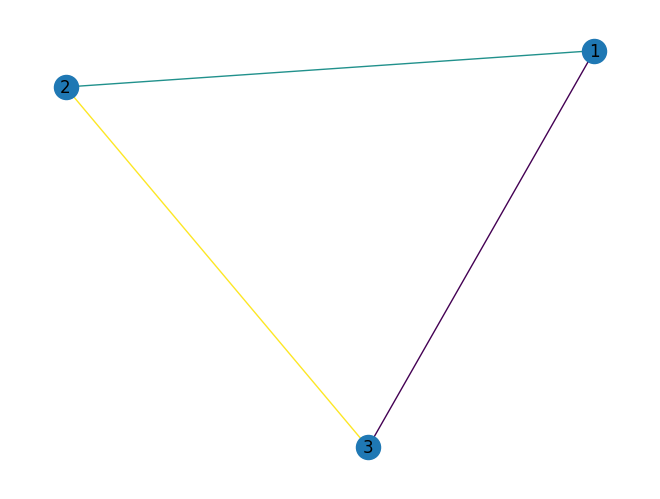

Time taken: 0.14179253578186035 seconds

Running test graph_5_edges.txt...
Best Coloring: [3 1 4 0 2]
Best Value: 0
Number of Colors: 5
[3 1 4 0 2]
Minimum edge coloring found.
Number of colors: 5
Number of iterations: 5


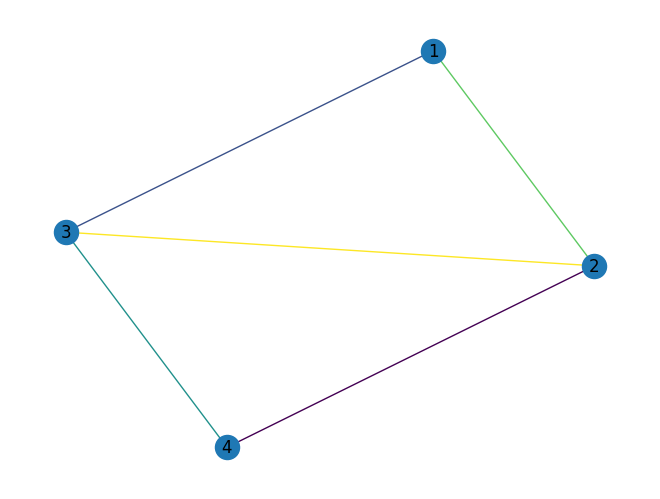

Time taken: 0.23809146881103516 seconds

Running test graph_5_edges_2.txt...
Best Coloring: [2 3 0 0 2]
Best Value: 0
Number of Colors: 3
[2 3 0 0 2]
Minimum edge coloring found.
Number of colors: 3
Number of iterations: 3


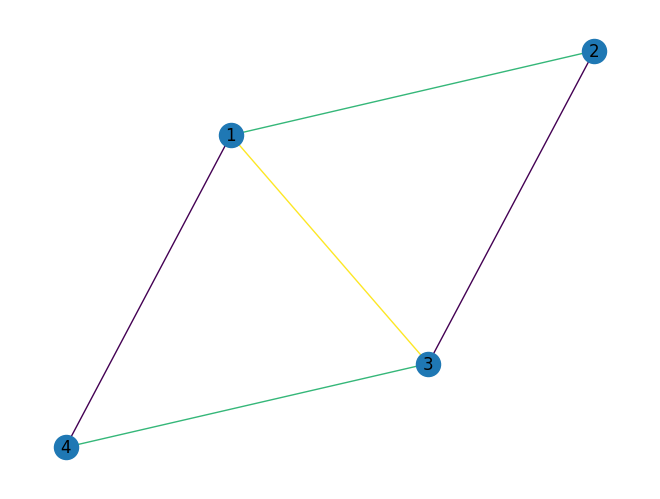

Time taken: 0.23937606811523438 seconds

Running test graph_6_edges.txt...
Best Coloring: [2 3 1 5 1 4]
Best Value: 0
Number of Colors: 5
[2 3 1 5 1 4]
Minimum edge coloring found.
Number of colors: 5
Number of iterations: 5


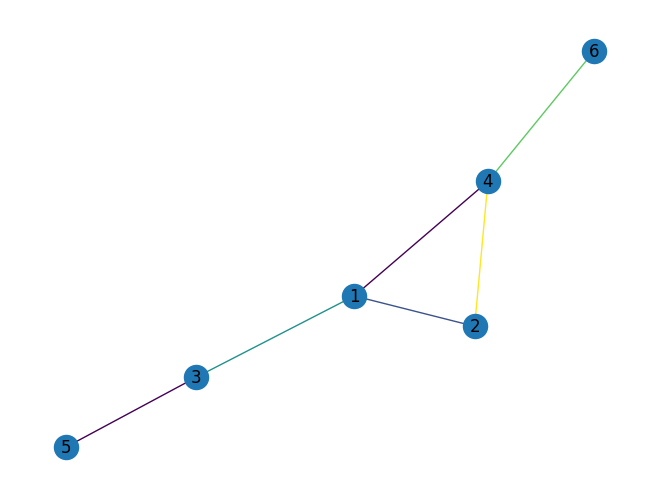

Time taken: 0.3034346103668213 seconds

Running test graph_7_edges.txt...
Best Coloring: [2 4 5 3 5 1 4]
Best Value: 0
Number of Colors: 5
[2 4 5 3 5 1 4]
Minimum edge coloring found.
Number of colors: 5
Number of iterations: 5


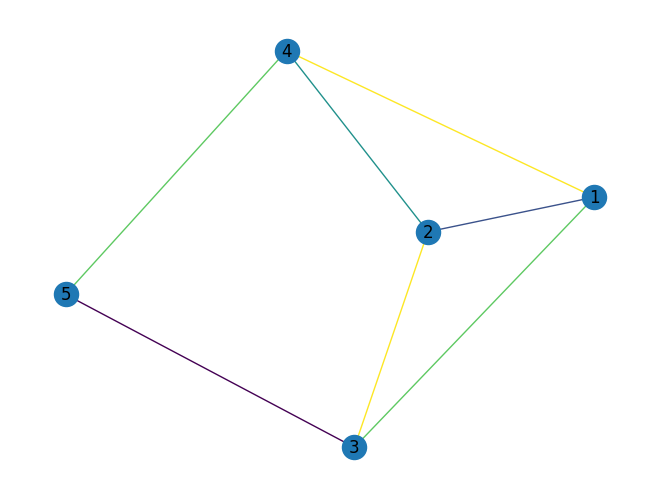

Time taken: 0.3631865978240967 seconds

Running test graph_7_edges_2.txt...
Best Coloring: [2 1 0 6 3 3 6]
Best Value: 0
Number of Colors: 5
[2 1 0 6 3 3 6]
Minimum edge coloring found.
Number of colors: 5
Number of iterations: 5


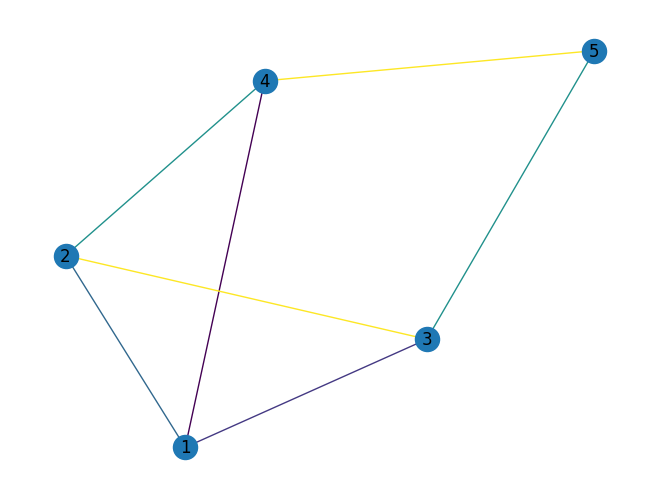

Time taken: 0.34928035736083984 seconds

Running test graph_7_edges_3.txt...
Best Coloring: [3 2 2 0 6 1 6]
Best Value: 0
Number of Colors: 5
[3 2 2 0 6 1 6]
Minimum edge coloring found.
Number of colors: 5
Number of iterations: 5


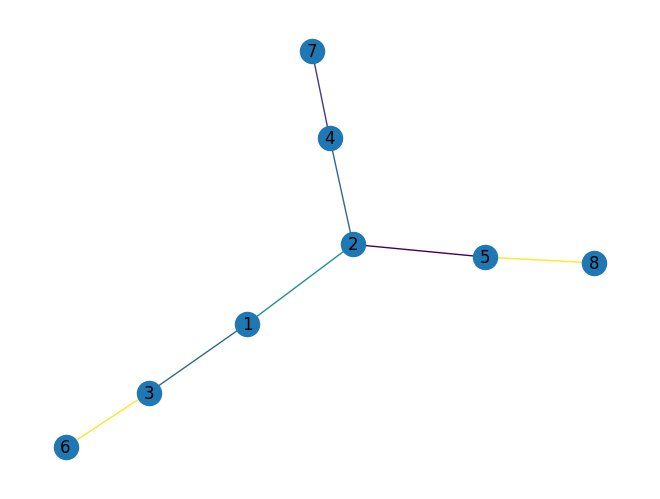

Time taken: 0.35475611686706543 seconds

Running test graph_8_edges.txt...
Best Coloring: [4 0 6 4 7 3 2 7]
Best Value: 0
Number of Colors: 6
[4 0 6 4 7 3 2 7]
Minimum edge coloring found.
Number of colors: 6
Number of iterations: 6


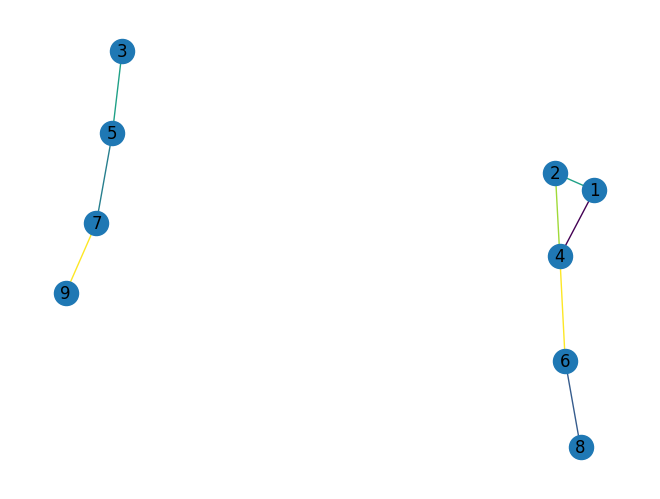

Time taken: 0.4107780456542969 seconds

Running test graph_9_edges.txt...
Best Coloring: [0 2 5 1 6 5 6 4 3]
Best Value: 0
Number of Colors: 7
[0 2 5 1 6 5 6 4 3]
Minimum edge coloring found.
Number of colors: 7
Number of iterations: 7


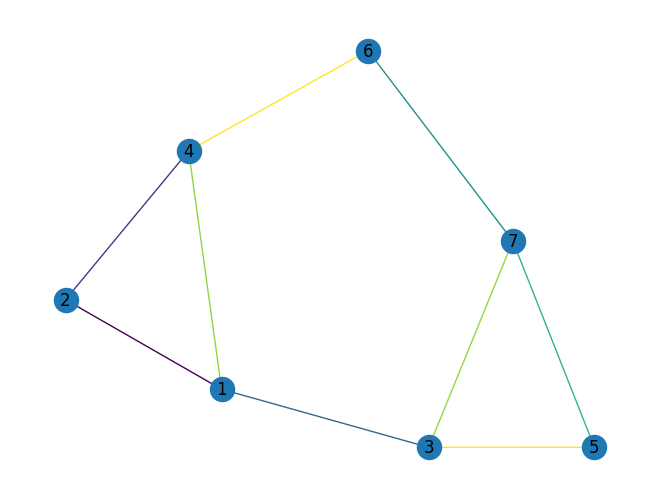

Time taken: 0.4868288040161133 seconds

Running test graph_9_edges_2.txt...
Best Coloring: [1 8 0 2 4 5 6 7 1]
Best Value: 0
Number of Colors: 8
[1 8 0 2 4 5 6 7 1]
Minimum edge coloring found.
Number of colors: 8
Number of iterations: 8


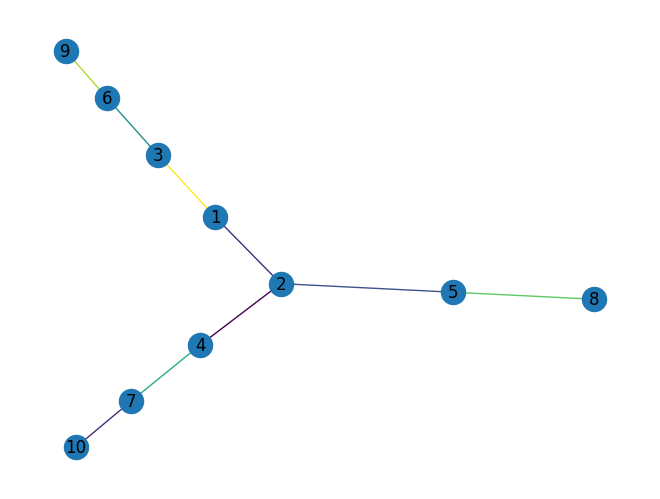

Time taken: 0.5403609275817871 seconds

Running test graph_10_edges.txt...
Best Coloring: [2 6 9 5 5 8 2 1 3 1]
Best Value: 0
Number of Colors: 7
[2 6 9 5 5 8 2 1 3 1]
Minimum edge coloring found.
Number of colors: 7
Number of iterations: 7


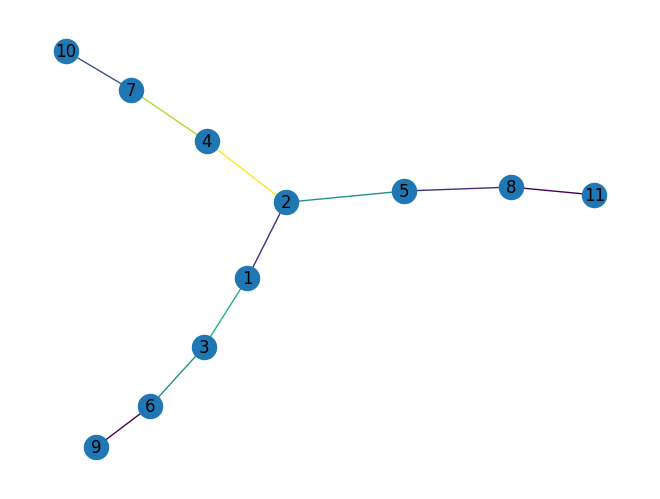

Time taken: 0.5752451419830322 seconds

Running test graph_10_edges_2.txt...
Best Coloring: [3 1 0 2 2 8 1 5 9 6]
Best Value: 0
Number of Colors: 8
[3 1 0 2 2 8 1 5 9 6]
Minimum edge coloring found.
Number of colors: 8
Number of iterations: 8


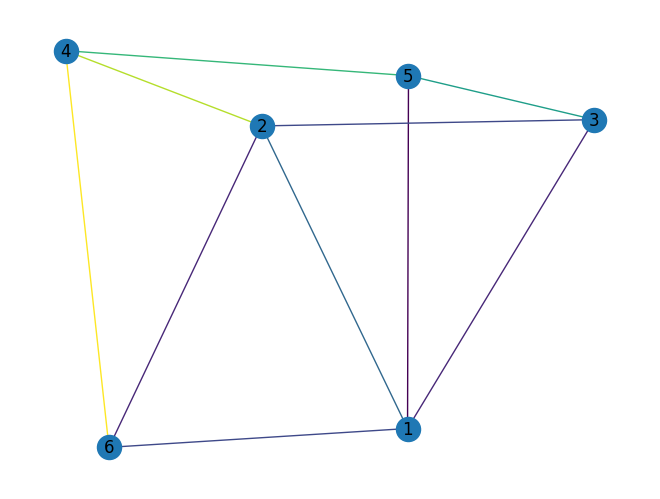

Time taken: 0.5392313003540039 seconds

Running test graph_10_edges_3.txt...
Best Coloring: [2 5 8 5 7 7 1 1 2 3]
Best Value: 0
Number of Colors: 6
[2 5 8 5 7 7 1 1 2 3]
Minimum edge coloring found.
Number of colors: 6
Number of iterations: 6


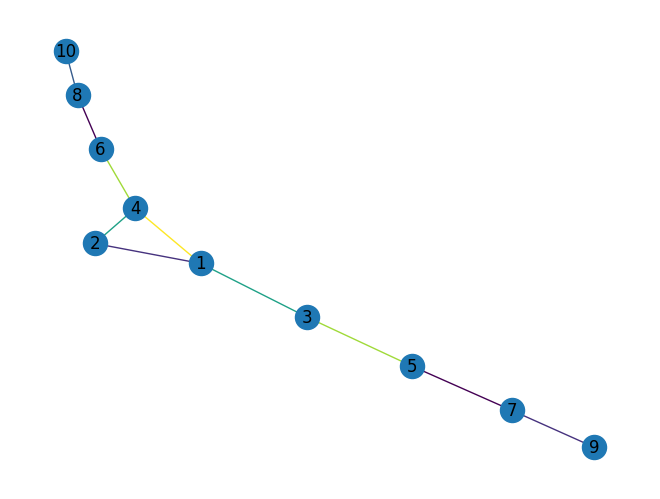

Time taken: 0.5681502819061279 seconds

Running test graph_11_edges.txt...
Best Coloring: [ 4 10  6 10  3  9  2  9  0  5  2]
Best Value: 0
Number of Colors: 8
[ 4 10  6 10  3  9  2  9  0  5  2]
Minimum edge coloring found.
Number of colors: 8
Number of iterations: 8


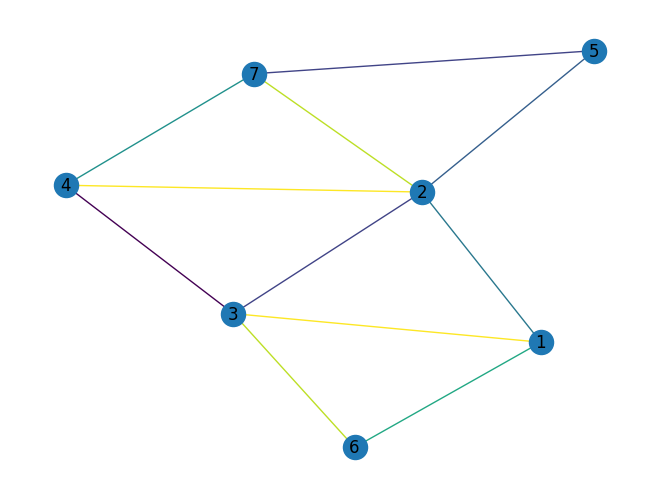

Time taken: 0.5884237289428711 seconds

Running test graph_11_edges_2s.txt...
Best Coloring: [10  3  5  3  0  4  7  0  4  2  3]
Best Value: 0
Number of Colors: 7
[10  3  5  3  0  4  7  0  4  2  3]
Minimum edge coloring found.
Number of colors: 7
Number of iterations: 7


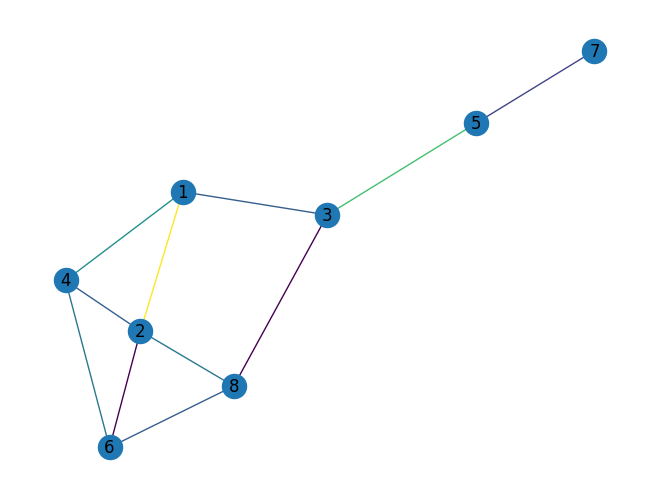

Time taken: 0.636946439743042 seconds

Running test graph_11_edges_3.txt...
Best Coloring: [ 6  1  8  4 10  1  3  4  4  5  2]
Best Value: 0
Number of Colors: 8
[ 6  1  8  4 10  1  3  4  4  5  2]
Minimum edge coloring found.
Number of colors: 8
Number of iterations: 8


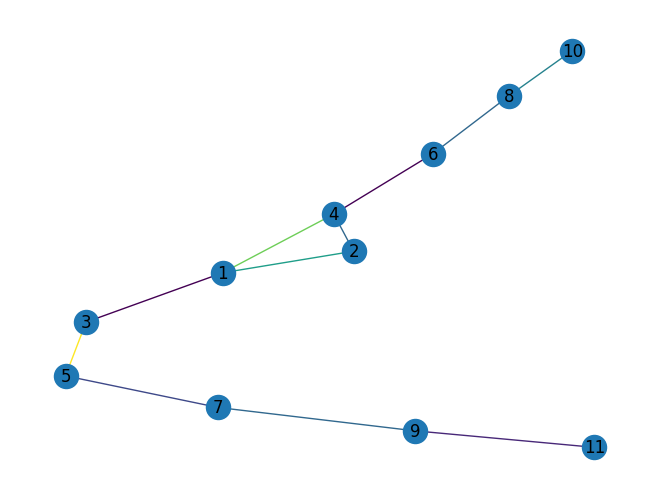

Time taken: 0.6413402557373047 seconds

Running test graph_11_edges_4.txt...
Best Coloring: [1 0 8 5 3 3 2 5 9 1 7]
Best Value: 0
Number of Colors: 8
[1 0 8 5 3 3 2 5 9 1 7]
Minimum edge coloring found.
Number of colors: 8
Number of iterations: 8


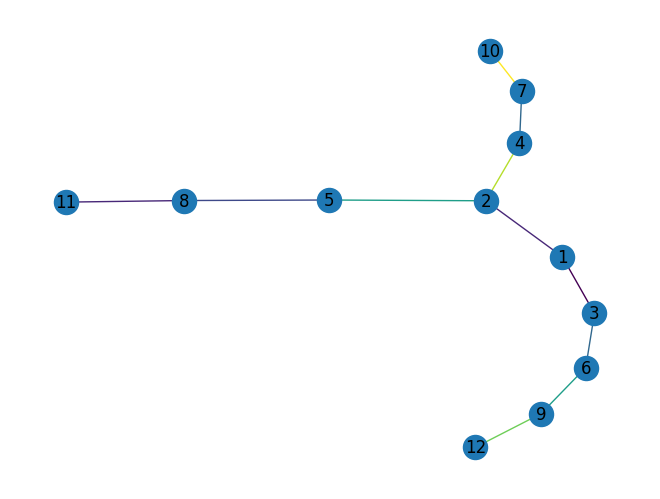

Time taken: 0.6713063716888428 seconds

Running test graph_12_edges.txt...
Best Coloring: [ 3 11  6  2  2  7  3  9  8  6  7 11]
Best Value: 0
Number of Colors: 7
[ 3 11  6  2  2  7  3  9  8  6  7 11]
Minimum edge coloring found.
Number of colors: 7
Number of iterations: 7


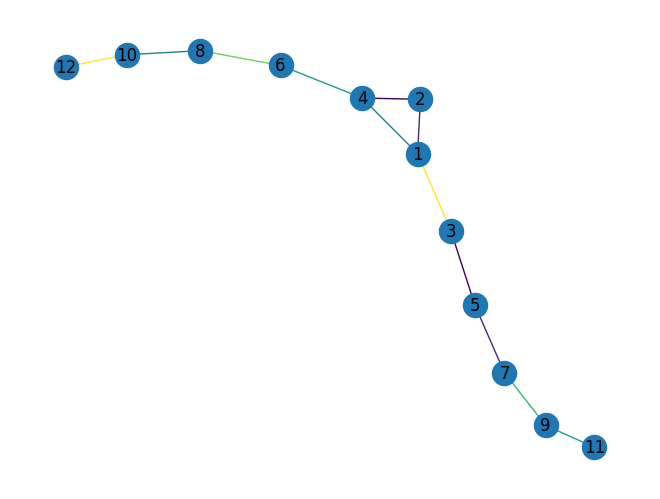

Time taken: 0.6911749839782715 seconds

Running test graph_12_edges_2.txt...
Best Coloring: [ 9 11  7 10  7  4  4  2  7  8 10  0]
Best Value: 0
Number of Colors: 8
[ 9 11  7 10  7  4  4  2  7  8 10  0]
Minimum edge coloring found.
Number of colors: 8
Number of iterations: 8


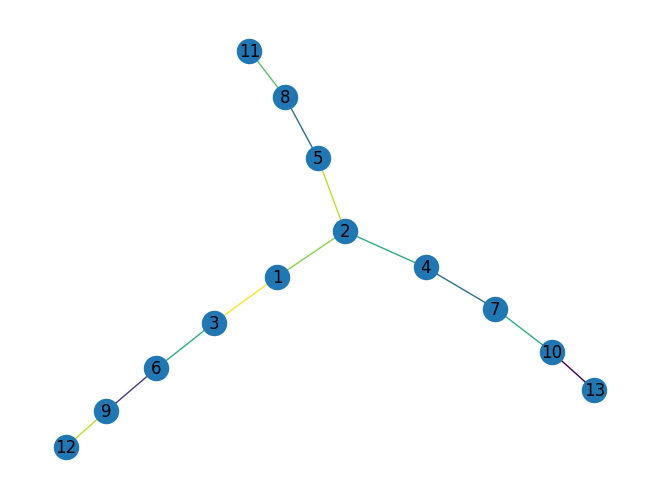

Time taken: 0.676438570022583 seconds

Running test graph_15_edges.txt...
Best Coloring: [ 1 13  8 14 12  2  2 10 14  0  7  8  1  1 12]
Best Value: 0
Number of Colors: 9
[ 1 13  8 14 12  2  2 10 14  0  7  8  1  1 12]
Minimum edge coloring found.
Number of colors: 9
Number of iterations: 9


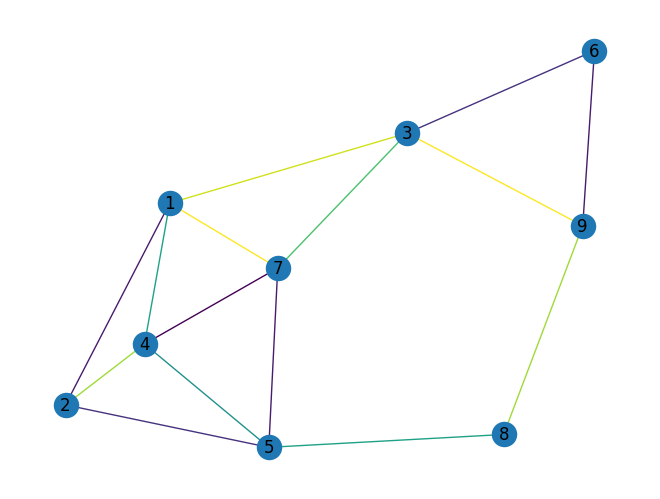

Time taken: 0.8406436443328857 seconds

Running test graph_100_edges.txt...
Best Coloring: [28 31 62 50 79 35 23 72  0 20  4 68 89 83 56 90 56 21 36 75  2  6  3 67
 62 30 67 64 40 19 78 36  7 22 44 16 72 25 57  2 22 10 67 37 46 74 30 66
 65 25 54 41 18 68 29 84 89 16 23 10 38 19 85 80 64 79 74 73 87 31 15 71
 67 16 31  3 62 69 86 50 18 16 33 76 15 82 43  0 12 51 72]
Best Value: 6
Number of Colors: 60
[28 31 62 50 79 35 23 72  0 20  4 68 89 83 56 90 56 21 36 75  2  6  3 67
 62 30 67 64 40 19 78 36  7 22 44 16 72 25 57  2 22 10 67 37 46 74 30 66
 65 25 54 41 18 68 29 84 89 16 23 10 38 19 85 80 64 79 74 73 87 31 15 71
 67 16 31  3 62 69 86 50 18 16 33 76 15 82 43  0 12 51 72]
Minimum edge coloring found.
Number of colors: 60
Number of iterations: 60


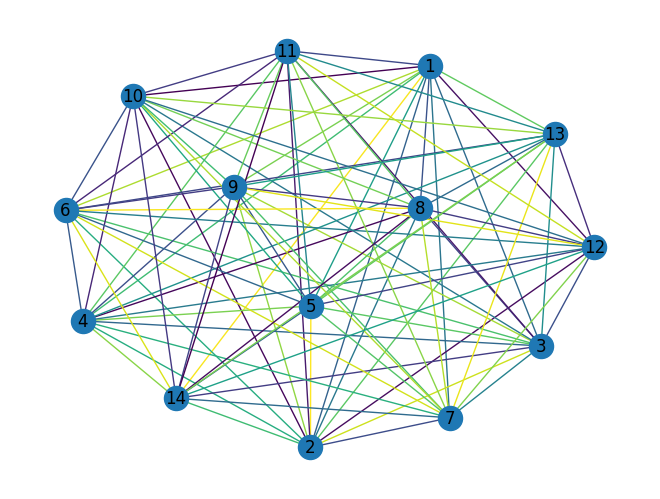

Time taken: 8.611046075820923 seconds

Running test graph_150_edges.txt...
Best Coloring: [136 164  93 163  17  27 158 148  91 139 171  12  64  39 157 110  51 188
 113 156  34 108 185 143  69 130  49  67  57 104 120 160 117  71  85 123
  23  52  89  91  68 165  99 160  76  59 158  74 103 189 178 127 120  70
   0  11  92   7  39  45 154  22 155  97  59  91  41 179  33 166 116  28
  61 189 105   8 127  50  13 102  63  58  99  15 156  78 100  25 188 126
   6 186 155  28   8  68  71 109 104 188  21  99 128  97 119  10 118 176
  31 184  93 108  72 170 128  92  78   2  35 146  15  58 160 157  36 172
  93  99 138  38 187  71  60  82  71 124  29   8  39 108  98 136 108  20
 143  11 106  82 158  72  85 171  22  17 166 158 114 107  87 182  64   1
 161  40  14 140  10  58 139 143 137 175  86 165  25 112  49  13 122  69
  94  29 176 134 148  78 127  56 126  48]
Best Value: 11
Number of Colors: 124
[136 164  93 163  17  27 158 148  91 139 171  12  64  39 157 110  51 188
 113 156  34 108 185 143  69

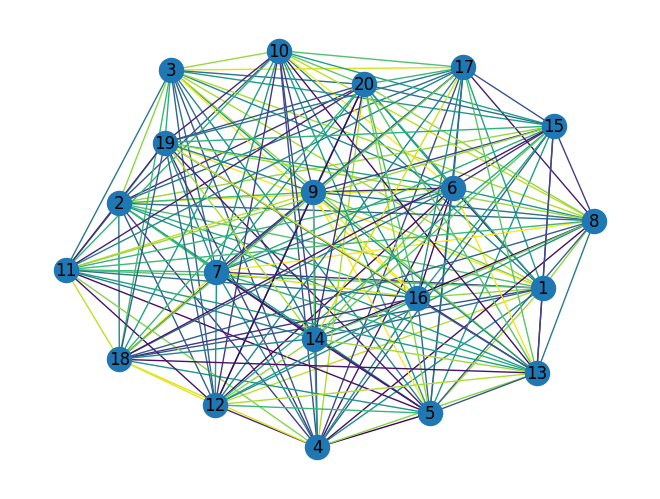

Time taken: 26.913727045059204 seconds



In [10]:
with open('./results/aco_results.txt', 'w') as result_file:
    result_file.write("")

run_tests('./tests')